Have you ever had a sports clash turn into a data analytics project? Well, this is what happened to me and a close group of friends during one casual conversation about sports!!

We decided to do some number crunching on 120 years of olympics to see which are the best performing countries at the olympics and what makes them great!

We got the [olympics dataset](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results) from kaggle, and decided to merge it with the country wise [gdp](https://www.kaggle.com/resulcaliskan/countries-gdps) and [population data](https://www.kaggle.com/centurion1986/countries-population).

With our weapons ready, its time to see who's BOSS!

In [1]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read in the data set
olympics = pd.read_csv('./Data/athlete_events.csv')
olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


### Data exploration and Basic Hygiene

#### 1) Missing Values

In [3]:
olympics.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

We find that height, weight and Age have a lot of missing values. Medals have a NaN in about 2,31,333 rows. These can be explained since not all participating athletes would win medals.

Let's replace these missing values by 'Did not win' or 'DNW'

In [4]:
olympics['Medal'].fillna('DNW', inplace = True)

In [5]:
# As expected the NaNs in the 'Medal' column disappear!
olympics.isnull().sum()

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64

#### 2) NOC - National Olympic Committee. 
These are responsible for organizing their people's participation in the Olympics.
Are all NOCs linked to a unique team? We can find this out by taking a unique subset of just the NOC and team columns and taking a value count.

In [6]:
olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head()

FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: NOC, dtype: int64

Hmm, This looks interesting. So NOC code 'FRA' is associated with 160 teams? That sounds prepostorous! Let's do a groupby and verify this.

In [7]:
olympics_NOC_Team = olympics.groupby(['NOC', 'Team'])[['Medal']].agg('count').reset_index()

len(olympics_NOC_Team.loc[olympics_NOC_Team['NOC'] == 'FRA', :])

160

So this is true! Okay let's use a master of NOC to country mapping to correct this.

In [8]:
# Lets read in the noc_country mapping first
noc_country = pd.read_csv('./Data/noc_regions.csv')
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

noc_country.head()

,NOC,Country
0,AFG,Afghanistan
1,AHO,Curacao
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra


We now need to merge the original dataset with the NOC master using the NOC code as the primary key. This has to be a left join since we want all participating countries to remain in the data even if their NOC-Country is not found in the master. We can easily correct those manually.

In [9]:
# merging
olympics_merge = olympics.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

olympics_merge.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands


Do we having NOCs in olympics that are not found in the NOC master data?

In [10]:
# Do we have NOCs that didnt have a matching country in the master?
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()

,NOC,Team
578,SGP,Singapore
6267,ROT,Refugee Olympic Athletes
44376,SGP,June Climene
61080,UNK,Unknown
64674,TUV,Tuvalu
80986,SGP,Rika II
108582,SGP,Singapore-2
235895,SGP,Singapore-1


So, we see that SGP, ROT, UNK and TUV from the olympics data find no match in the NOC master data. Looking at their 'Team' names we can manually insert the correct values into the olympics data.

Let's put these values in Country - <br>
    1. SGP - Singapore
    2. ROT - Refugee Olympic Athletes
    3. UNK - Unknown
    4. TUV - Tuvalu

In [11]:
# Replace missing Teams by the values above.
#olympics_merge.loc[olympics_merge['Country'].isnull(), ['Country']] = olympics_merge['Team']

olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

Checking again for mapping of NOC to team we find that each is mapped to a single value! Nice!

In [12]:
olympics_merge.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head()

PNG    1
BUL    1
UGA    1
TKM    1
SCG    1
Name: NOC, dtype: int64

### Merge GDP data

In [13]:
# Glance at the data.
w_gdp = pd.read_csv('.\Data\world_gdp.csv', skiprows = 3)
w_gdp.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,9.843842e+09,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.004633e+10,2.005019e+10,1.921556e+10,1.946902e+10
1,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.070101e+10,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.133526e+10,1.186387e+10
2,Algeria,DZA,GDP (current US$),NY.GDP.MKTP.CD,2.723649e+09,2.434777e+09,2.001469e+09,2.703015e+09,2.909352e+09,3.136259e+09,...,1.349770e+11,1.710010e+11,1.372110e+11,1.612070e+11,2.000190e+11,2.090590e+11,2.097550e+11,2.138100e+11,1.658740e+11,1.590490e+11
3,American Samoa,ASM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5.200000e+08,5.630000e+08,6.780000e+08,5.760000e+08,5.740000e+08,6.440000e+08,6.410000e+08,6.430000e+08,6.590000e+08,6.580000e+08
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.016972e+09,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.858518e+09


Looking at the data we find that 'Indicator Name' and 'Indicator Code' have only one value in the entire column. We can therefore safely remove these columns from the dataset.

In [14]:
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

In [15]:
w_gdp.head()

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,AFG,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,...,9.843842e+09,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.004633e+10,2.005019e+10,1.921556e+10,1.946902e+10
1,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.070101e+10,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.133526e+10,1.186387e+10
2,Algeria,DZA,2.723649e+09,2.434777e+09,2.001469e+09,2.703015e+09,2.909352e+09,3.136259e+09,3.039835e+09,3.370843e+09,...,1.349770e+11,1.710010e+11,1.372110e+11,1.612070e+11,2.000190e+11,2.090590e+11,2.097550e+11,2.138100e+11,1.658740e+11,1.590490e+11
3,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.200000e+08,5.630000e+08,6.780000e+08,5.760000e+08,5.740000e+08,6.440000e+08,6.410000e+08,6.430000e+08,6.590000e+08,6.580000e+08
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.016972e+09,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.858518e+09


In [16]:
# The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


Before we actually merge, lets check if NOCs in the olympics data match with those in the Country Code.

In [17]:
len(list(set(olympics_merge['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108

So, 108 NOCs in the olympics dataset dont have representation in the gdp data country codes. Is the name of the country a better way to merge?

In [18]:
len(list(set(olympics_merge['Team'].unique()) - set(w_gdp['Country Name'].unique())))

5

Aha! only 5! What countries are these? So maybe what I can do is, add a country code for each Team in the olympics dataset to help ease things.

In [19]:
# Merge to get country code
olympics_merge_ccode = olympics_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

In [20]:
olympics_merge_gdp.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark,DNK,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,NLD,2.585680e+11


### Merge Population Data

In [21]:
# Read in the population data
w_pop = pd.read_csv('.\Data\world_pop.csv')
w_pop.head()

,Country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281


Indicator Name and Indicator Code have the same value for all rows. We can safely remove these rows.

In [22]:
w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

Reshape the data to bring years into a single column.

In [23]:
w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])
w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


Before we merge, lets check the matches between Country code in olympics_merge_gdp and country code in w_pop.

In [24]:
list(set(olympics_merge_gdp['Country Code']) - set(w_pop['Country Code'])) 

[nan, 'SSD', 'ERI']

In [25]:
olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)

In [26]:
olympics_complete.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark,DNK,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,NLD,2.585680e+11,1.476009e+07


There are a lot of missing values in the data, this is to be attributed to the countries not found in the GDP and population masters and also the fact that Population and GDP are only for 1961 onwards while Olympics data is from 1896.

In [27]:
olympics_complete.isnull().sum()

ID                  0
Name                0
Sex                 0
Age              9474
Height          60171
Weight          62875
NOC                 0
Games               0
Year                0
Season              0
City                0
Sport               0
Event               0
Medal               0
Team                0
Country Code     1245
GDP             86777
Population      64972
dtype: int64

In [28]:
# Lets take data from 1961 onwards only and for summer olympics only
olympics_complete_subset = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

In [29]:
olympics_complete_subset = olympics_complete_subset.reset_index()

In [30]:
olympics_complete_subset.head()

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09
1,1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09
2,31,12,Jyri Tapani Aalto,M,31.0,172.0,70.0,FIN,2000 Summer,2000,Summer,Sydney,Badminton,Badminton Men's Singles,DNW,Finland,FIN,1.255400e+11,5.176209e+06
3,32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,FIN,1996 Summer,1996,Summer,Atlanta,Sailing,Sailing Women's Windsurfer,DNW,Finland,FIN,1.320990e+11,5.124573e+06
4,33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,FIN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Women's Windsurfer,DNW,Finland,FIN,1.255400e+11,5.176209e+06


### Data Visualization

### Who has the most medals across all editions of the olympics?
Medal tally is the sum of all medals won.

Let's create a column that captures whether or not a medal was won! It would be 1 if Medal column says Gold, Silver or Bronze and 0 otherwise.

In [31]:
olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'DNW', 0, 1)

Who are the greatest olympics playing nations of all time? Lets make a pivot table to find out!

In [32]:
# Medal Tally.
medal_tally = olympics_complete_subset.groupby(['Year','Team'])['Medal_Won'].agg('sum').reset_index()
#medal_tally['Year'] = pd.to_datetime(medal_tally['Year'], format = "%Y")

In [33]:
pd.pivot_table(medal_tally,
              index = 'Team',
              columns = 'Year',
              values = 'Medal_Won',
              aggfunc = 'sum',
              margins = True).sort_values('All', ascending = False)[1:5]

Year,1964,1968,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016,All
Team,,,,,,,,,,,,,,,
USA,169.0,166.0,171.0,164.0,NaN,352.0,207.0,224.0,259.0,242.0,263.0,317.0,248.0,264.0,3046
Russia,174.0,192.0,214.0,286.0,442.0,NaN,300.0,220.0,115.0,187.0,189.0,142.0,140.0,115.0,2716
Germany,116.0,103.0,253.0,273.0,264.0,158.0,296.0,198.0,124.0,118.0,149.0,99.0,94.0,159.0,2404
Australia,44.0,51.0,20.0,23.0,13.0,52.0,35.0,57.0,132.0,183.0,157.0,149.0,114.0,82.0,1112


USA, Russia, Germany and Australia are the best countries of all time when it comes to medal tallies. What do the yearwise medal tallies look like?

Text(0.5,1,'Olympic Performance Comparison')

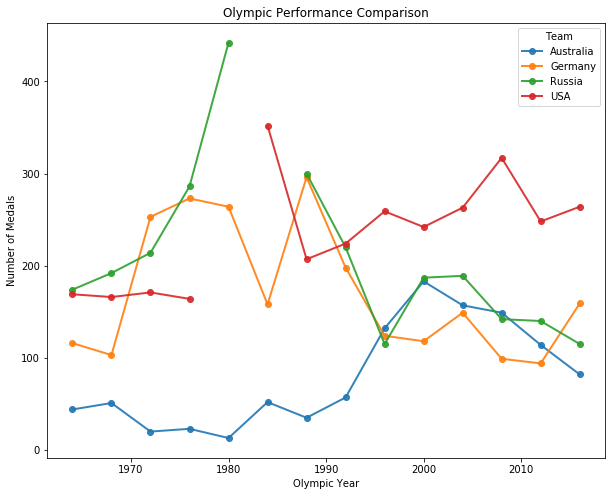

In [81]:
req_countries = ['USA', 'Russia', 'Germany', 'Australia']
row_mask_1 = medal_tally['Team'].map(lambda x: x in req_countries)

# Making a pivot table with the medal tallies
year_team_medals = pd.pivot_table(medal_tally.loc[row_mask_1, :],
                                  index = 'Year',
                                  columns = 'Team',
                                  values = 'Medal_Won',
                                  aggfunc = 'sum')

# plotting the medal tallies
year_team_medals.plot(linestyle = '-', marker = 'o', alpha = 0.9, figsize = (10,8), linewidth = 2)
xlabel('Olympic Year')
ylabel('Number of Medals')
title('Olympic Performance Comparison')

**Interesting Insight 1**: The blank value at 1980 for USA is not a data error! In 1980, the United States led a boycott of the Summer Olympic Games in Moscow to protest the late 1979 Soviet invasion of Afghanistan. In total, 65 nations refused to participate in the games, whereas 80 countries sent athletes to compete, India being one of those.

**Interesting Insight 2**:The missing point at 1984 for Russia is no error either! The boycott of the 1984 Summer Olympics in Los Angeles followed four years after the U.S.-led boycott of the 1980 Summer Olympics in Moscow. The boycott involved 14 Eastern Bloc countries and allies, led by the Soviet Union, which initiated the boycott on May 8, 1984.

Lets plot a breakup of medal tally by the medal type - Gold, Silver, Bronze

Text(0,0.5,'Country')

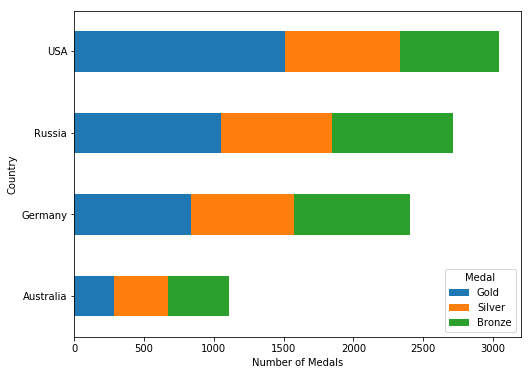

In [36]:
row_mask_2 = olympics_complete_subset['Team'].map(lambda x: x in req_countries)

medal_tally_specific = pd.pivot_table(olympics_complete_subset.loc[row_mask_2,:],
                                     index = 'Team',
                                     columns = 'Medal',
                                      values = 'Medal_Won',
                                     aggfunc = 'count').drop('DNW', axis = 1)
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'barh', stacked = True, figsize = (8,6))
xlabel('Number of Medals')
ylabel('Country')

Surprisingly, countries are also in order of gold medal tallies!

### What sports are these countries best at? 
Those would be sports that they have got the most gold medals for across the years.

In [37]:
best_team_sports = pd.pivot_table(olympics_complete_subset[row_mask_2],
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won',
                                  aggfunc = 'sum',
                                  fill_value = 0).drop('DNW', axis = 1).sort_values(['Team', 'Gold'], 
                                                                                    ascending = [True, False]).reset_index()
best_team_sports.groupby('Team').head(5)

Medal,Team,Event,Bronze,Gold,Silver
0,Australia,Hockey Women's Hockey,0,48,0
1,Australia,Swimming Women's 4 x 100 metres Freestyle Relay,5,17,5
2,Australia,Hockey Men's Hockey,79,16,45
3,Australia,Swimming Women's 4 x 100 metres Medley Relay,0,14,30
4,Australia,Water Polo Women's Water Polo,26,13,0
347,Germany,Hockey Men's Hockey,32,67,32
348,Germany,Rowing Men's Coxed Eights,18,46,27
349,Germany,"Equestrianism Mixed Dressage, Team",0,39,6
350,Germany,Rowing Men's Quadruple Sculls,8,28,0
351,Germany,Rowing Women's Coxed Eights,9,27,0


Okay, so we observe that team sports are coming at the top the most times. This would be because when a team wins gold, the records would have details of each player that won and the count would multiply times the team members.
We need to correct for this to get the actual sports that these countries are good at.

#### If a team wins more than one gold medal for an event in an edition of the olympics, then that event is a team event.

In [38]:
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

team_sports = identify_team_events['Event'].unique()

So, what events are team events? The list below gives names of each event where in a single edition multiple golds were given. Going through the list, however, we found that some events have crept in which are not usually team events. Some examples include - <br>
    1. Gymnastics Women's Balance Beam
    2. Gymnastics Men's Horizontal Bar
    3. Swimming Women's 100 metres Freestyle
    4. Swimming Men's 50 metres Freestyle

Upon analysis, I found that these are actually single events but because two athletes had the same score/time, both were awarded the gold medal. We need to remove these events from the list of team sports

In [39]:
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar", 
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_sports = list(set(team_sports) - set(remove_sports))

["Canoeing Women's Kayak Doubles, 500 metres", "Rowing Men's Coxed Eights", "Baseball Men's Baseball", "Swimming Women's 4 x 100 metres Freestyle Relay", "Softball Women's Softball", "Diving Women's Synchronized Springboard", 'Tennis Mixed Doubles', "Cycling Men's Madison", "Sailing Men's Skiff", "Rowing Men's Coxed Fours", "Volleyball Men's Volleyball", "Table Tennis Men's Doubles", "Water Polo Women's Water Polo", "Badminton Men's Doubles", "Fencing Men's epee, Team", "Rowing Men's Lightweight Double Sculls", "Fencing Men's Sabre, Team", "Cycling Men's 100 kilometres Team Time Trial", "Rhythmic Gymnastics Women's Group", "Synchronized Swimming Women's Duet", "Water Polo Men's Water Polo", "Archery Women's Team", "Volleyball Women's Volleyball", "Canoeing Men's Kayak Doubles, 500 metres", "Tennis Men's Doubles", 'Sailing Mixed Skiff', "Football Women's Football", "Diving Men's Synchronized Platform", "Archery Men's Team", "Rowing Women's Coxless Pairs", "Modern Pentathlon Men's Team",

The next thing we need to do is add a column in the dataset that correctly identifies whether the event in the given record is a team event.

In [51]:
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

medal_mask = olympics_complete_subset['Medal_Won'] == 1

olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + olympics_complete_subset['Team_Event']

olympics_complete_subset.head()

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,...,Event,Medal,Team,Country Code,GDP,Population,Medal_Won,Team_Event,Single_Event,Event_Category
0,0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,...,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09,0,0,0,0
1,1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,...,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09,0,0,0,0
2,31,12,Jyri Tapani Aalto,M,31.0,172.0,70.0,FIN,2000 Summer,2000,...,Badminton Men's Singles,DNW,Finland,FIN,1.255400e+11,5.176209e+06,0,0,0,0
3,32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,FIN,1996 Summer,1996,...,Sailing Women's Windsurfer,DNW,Finland,FIN,1.320990e+11,5.124573e+06,0,0,0,0
4,33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,FIN,2000 Summer,2000,...,Sailing Women's Windsurfer,DNW,Finland,FIN,1.255400e+11,5.176209e+06,0,0,0,0


Now, its time to calculate medal tally agnostic of the team size - one gold means one gold for an event. To do this we divide the number of medals by the count of winning team members. How do we get the team members? Sum of team_event column should do that for us!

In [63]:
medal_tally_agnostic = olympics_complete_subset[row_mask_2].\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

medal_tally_agnostic.sort_values('Medal_Won', ascending = False).head(25)

,Year,Team,Event,Medal,Medal_Won,Event_Category,Medal_Won_Corrected
8883,2004,Australia,Baseball Men's Baseball,Silver,24,24,1.0
10723,2008,USA,Baseball Men's Baseball,Bronze,24,24,1.0
8601,2000,USA,Baseball Men's Baseball,Gold,24,24,1.0
7468,1996,USA,Baseball Men's Baseball,Bronze,20,20,1.0
237,1964,Germany,Football Men's Football,Bronze,19,19,1.0
2028,1972,Russia,Football Men's Football,Bronze,19,19,1.0
12314,2016,Germany,Football Women's Football,Gold,18,18,1.0
1807,1972,Germany,Hockey Men's Hockey,Gold,18,18,1.0
5187,1988,Russia,Football Men's Football,Gold,18,18,1.0
4887,1988,Germany,Football Men's Football,Bronze,18,18,1.0


To get the sports, teams are best at, we now aggregate the medal_tally_agnostic dataframe as we did earlier.

In [68]:
best_team_sports = pd.pivot_table(medal_tally_agnostic,
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum',
                                  fill_value = 0).sort_values(['Team', 'Gold'], ascending = [True, False]).reset_index()

best_team_sports.groupby('Team').head(5)

Medal,Team,Event,Bronze,DNW,Gold,Silver
0,Australia,"Swimming Men's 1,500 metres Freestyle",4,0,5,5
1,Australia,Swimming Men's 400 metres Freestyle,3,0,4,3
2,Australia,"Equestrianism Mixed Three-Day Event, Team",3,0,3,1
3,Australia,Hockey Women's Hockey,0,0,3,0
4,Australia,Sailing Men's Two Person Dinghy,0,0,3,1
347,Germany,"Equestrianism Mixed Dressage, Team",0,0,11,2
348,Germany,"Canoeing Women's Kayak Doubles, 500 metres",2,0,7,4
349,Germany,Rowing Men's Quadruple Sculls,2,0,7,0
350,Germany,Rowing Women's Quadruple Sculls,1,0,6,1
351,Germany,Athletics Men's Discus Throw,2,0,5,4


Much Better! This now presents a better picture of the sports competencies of these nations! What we have done is essentially consider one win in a team event in one edition mean one medal. So what the above table shows us is how many times does a country win repeatedly at an event! Note that Basketball was in the top for USA even before and it is still at number 5!

### Next we look at the size of the olympic contingent that these countries send to the Olympics!

Text(0.5,1,'Olympic Medal Tally')

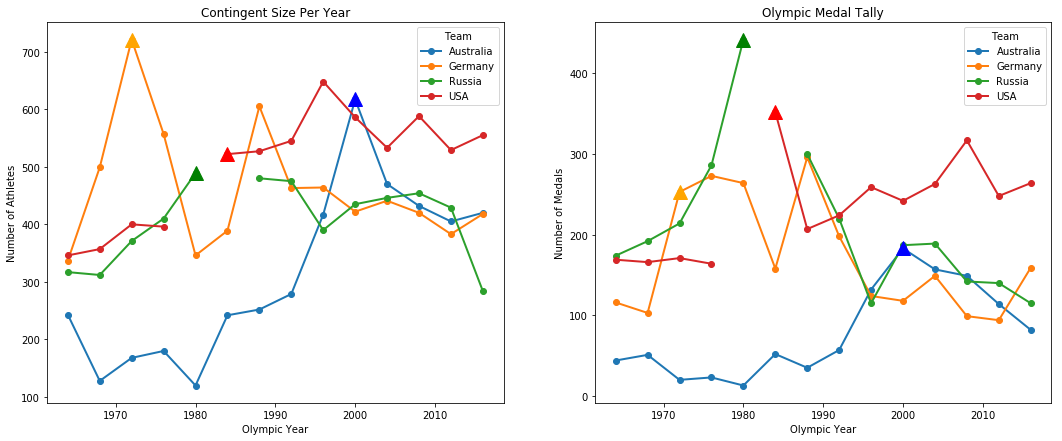

In [113]:
# Get year wise team wise athletes.
year_team_athelete = olympics_complete_subset.loc[row_mask_2, ['Year','Team', 'Name']].drop_duplicates()

# sum these up to get total contingent size.
contingent_size = pd.pivot_table(year_team_athelete,
                                 index = 'Year',
                                 columns = 'Team',
                                 values = 'Name',
                                 aggfunc = 'count')

fig, (ax1, ax2) = subplots(nrows = 1,
                          ncols = 2,
                          sharex = True,
                          figsize = (18,7))

contingent_size.plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2)
ax1.plot(1972, contingent_size.loc[1972, 'Germany'], marker = '^', color = 'orange', ms = 14)
ax1.plot(1980, contingent_size.loc[1980, 'Russia'], marker = '^', color = 'green', ms = 14)
ax1.plot(1984, contingent_size.loc[1984, 'USA'], marker = '^', color = 'red', ms = 14)
ax1.plot(2000, contingent_size.loc[2000, 'Australia'], marker = '^', color = 'blue', ms = 14)
ax1.set_xlabel('Olympic Year')
ax1.set_ylabel('Number of Athletes')
ax1.set_title('Contingent Size Per Year')

year_team_medals.plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2)
ax2.plot(1972, year_team_medals.loc[1972, 'Germany'], marker = '^', color = 'orange', ms = 14)
ax2.plot(1980, year_team_medals.loc[1980, 'Russia'], marker = '^', color = 'green', ms = 14)
ax2.plot(1984, year_team_medals.loc[1984, 'USA'], marker = '^', color = 'red', ms = 14)
ax2.plot(2000, year_team_medals.loc[2000, 'Australia'], marker = '^', color = 'blue', ms = 14)
ax2.set_xlabel('Olympic Year')
ax2.set_ylabel('Number of Medals')
ax2.set_title('Olympic Medal Tally')

It is interesting to see that for each of these countries, a point of peak in the contingent size translates directly to a peak in the medal tally! These have been marked as large triangles on the plots

### Are fit athletes the reason for these countries medal tally?

721.0

### Is home advantage a thing?
Do countries win more when they are playing at home?

### Are there some commonalities between the countries?
Are there common things they are all good at?

In [127]:
team_commonalities = best_team_sports.merge(olympics_complete_subset.loc[:,['Sport', 'Event']].drop_duplicates(),
                                           left_on = 'Event',
                                           right_on = 'Event')

team_commonalities = team_commonalities.sort_values(['Team', 'Gold'], ascending = [True, False])
team_commonalities = team_commonalities.groupby('Team').head(10).reset_index()

pd.pivot_table(team_commonalities,
              index = 'Sport',
              columns = 'Team',
              values = 'Event',
              aggfunc = 'count',
              fill_value = 0,
              margins = True).sort_values('All', ascending = False)[1:]

Team,Australia,Germany,Russia,USA,All
Sport,,,,,
Swimming,5,0,0,5,10
Athletics,1,1,2,4,8
Canoeing,0,4,0,0,4
Wrestling,0,0,4,0,4
Rowing,0,3,0,0,3
Cycling,1,1,0,0,2
Equestrianism,1,1,0,0,2
Basketball,0,0,0,1,1
Fencing,0,0,1,0,1


#### Interesting Insights 3:
1. One thing all nations have in their top 10 sports is athletics!
2. Australia and US have a penchant for swimming events!
3. Germany is solid in rowing and canoeing!
4. Russia loves to wrestle!

In [60]:
identify_team_events[identify_team_events['Event'] == "Baseball Men's Baseball"]

Medal,Team,Year,Event,Bronze,Gold,Silver
16465,Cuba,1992,Baseball Men's Baseball,0,20,0
16559,Cuba,1996,Baseball Men's Baseball,0,20,0
16777,Cuba,2004,Baseball Men's Baseball,0,24,0
60016,South Korea,2008,Baseball Men's Baseball,0,24,0
71539,USA,2000,Baseball Men's Baseball,0,24,0


In [62]:
# To check data by filtering rows!

event_mask = olympics_complete_subset['Event'] == "Baseball Men's Baseball"
team_mask = olympics_complete_subset['Team'] == "Australia"
year_mask = olympics_complete_subset['Year'] == 2004
medal_mask = olympics_complete_subset['Medal_Won'] == 1

olympics_complete_subset.loc[event_mask & year_mask & medal_mask & team_mask, :]

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,...,Event,Medal,Team,Country Code,GDP,Population,Medal_Won,Team_Event,Single_Event,Event_Category
4628,6780,3803,Craig Anthony Anderson,M,23.0,187.0,86.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
17333,29085,15041,"Thomas Robert ""Tom"" Brice",M,22.0,195.0,98.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
19294,32495,16704,Adrian Mark Burnside,M,27.0,193.0,100.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
41115,69486,35410,Gavin Fingleson,M,28.0,177.0,87.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
48431,81976,41627,Paul Gonzalez,M,35.0,186.0,86.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
69806,119317,60409,"Nicholas Andrew ""Nick"" Kimpton",M,20.0,185.0,85.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
69922,119544,60516,Brendan Robert Kingman,M,31.0,186.0,112.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
79822,137706,69216,Craig Edward Lewis,M,27.0,195.0,100.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
81948,141177,70852,Graeme John Lloyd,M,37.0,200.0,108.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
100747,171902,86379,"David Wayne ""Dave"" Nilsson",M,34.0,193.0,110.0,AUS,2004 Summer,2004,...,Baseball Men's Baseball,Silver,Australia,AUS,6.133300e+11,20127400.0,1,1,0,1
